# Credit Default Prediction: Code Notebook with Annotations
*Code is in Python using Jupyter Notebook* \
*Exported using LaTex* \
*(n) indicates code reference was used, go to code references at the bottom to find references with links*

#**Table of contents**

---

## 1. [Exploratory Data Analysis](#sect1)
* first look at data
* comparing defaulting and non-defaulting population
* basic graphing of data
* testing validity of data
* checking for problems that need to be addressed before fitting models

## 2. [Data Preprocessing - Logistic Regression](#sect2)
* variable selection
* reducing collinearity in explanatory variables
* Normalization of data

## 3. [Model Building and Testing - Logistic Regression](#sect3)
* Hyperparameter tuning
* Building and testing model
* Interpreation of model

## 4. [Data Preprocessing - Random Forests](#sect4)
* variable selection
* missing value imputation

## 5. [Model Building and Testing - Random Forests](#sect5)
* Hyperparameter tuning
* Building and testing model
* Interpreation of model

## 6. [Comparing Models](#sect6)
* ROC curve comparison

## 7. [Code References](#sect7)
* giving credit to people who helped us develop our code

#  **Exploratory Data Analysis** <a name="sect1"></a>

Importing packages used in our analysis: \
Numpy for scientific computing \
Pandas for dealing with data tables \
Matplotlib and seaborn for visualization \
Statsmodels for calculating multicollinearity \
Sklearn for building models and model interpretation, hyperparameter tuning \
Autoimpute for imputation

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from autoimpute.imputations import SingleImputer

Importing all of our data sets:

In [235]:
df_test = pd.read_csv('Simulated_Data_Test.csv')
df_train = pd.read_csv('Simulated_Data_Train.csv')
df_validation = pd.read_csv('Simulated_Data_Validation.csv')

The first thing is to just get a basic summary of the train data we were given by looking at the raw data. \
\
As we can see below, all variables except for state are of type float, and upon first glance it seems that the train data has imported correctly.

In [240]:
print(df_train.sample)
print(df_train.dtypes)

<bound method NDFrame.sample of        tot_credit_debt  avg_card_debt  credit_age  credit_good_age  card_age  \
0             80826.71       15872.99       300.0            114.0     292.0   
1             96052.60       12178.02       281.0            102.0     232.0   
2             75212.76       12052.24       261.0            149.0     260.0   
3             70727.84        8416.80       227.0             93.0     223.0   
4             41604.47       10611.97       249.0            136.0     241.0   
...                ...            ...         ...              ...       ...   
19995        104765.01       13905.40       182.0             84.0     165.0   
19996         83990.07       10325.02       320.0            129.0     280.0   
19997        107606.69       17838.79       290.0            168.0     271.0   
19998         78787.72       11447.61       208.0            104.0     194.0   
19999         78296.90       10053.16       348.0            175.0     299.0   

       

Before we get ahead of ourselves, we want to check that there is nothing wrong with the test and validation datasets when compared to the train dataset. \
\
Everything seems to be in order: correct data types, same number of variables, nothing seems out of the ordinary.

In [236]:
print(df_validation.sample)
print(df_validation.dtypes)

<bound method NDFrame.sample of       tot_credit_debt  avg_card_debt  credit_age  credit_good_age  card_age  \
0            63651.27        9019.99       484.0            242.0     395.0   
1           105559.29       16692.19       212.0            118.0     211.0   
2            96062.99       10509.13       255.0            123.0     180.0   
3            84417.40       13873.96       330.0            175.0     328.0   
4           100623.91       15592.09       207.0            101.0     128.0   
...               ...            ...         ...              ...       ...   
2995         90748.88       11481.81       274.0            161.0     268.0   
2996        101930.98       15242.30       243.0            161.0     213.0   
2997         74738.73       12175.49       351.0            179.0     271.0   
2998        120357.58       14477.70       308.0            178.0     298.0   
2999         74240.17       11873.45       341.0            181.0     333.0   

      non_mtg_acc_p

In [238]:
print(df_test.sample)
print(df_test.dtypes)

<bound method NDFrame.sample of       tot_credit_debt  avg_card_debt  credit_age  credit_good_age  card_age  \
0            40477.81        7766.64       322.0            181.0     235.0   
1           106760.98       16606.98       323.0            144.0     273.0   
2           121428.34       13910.13       361.0            189.0     350.0   
3            96515.05       15436.78       344.0            203.0     343.0   
4           123760.22       14213.25       370.0            177.0     347.0   
...               ...            ...         ...              ...       ...   
4995         90788.44       11646.36       203.0             80.0     180.0   
4996         91052.81       16505.20       291.0            122.0     285.0   
4997         71061.71       11512.18       348.0            191.0     303.0   
4998         82162.45       10014.90       357.0            163.0     339.0   
4999        116943.32       18042.56       192.0             99.0     189.0   

      non_mtg_acc_p

Now we will garner summary stats about the all the variables. Important notes:
- reported income mean is much higher than national mean.
- 7.93% of population in train data set has defaulted
- 25.855% of population already had an account with XYZ
- All utilization variables have a mean around 50%
- Standard deviation is relatively large for average card debt (0.66 as a proportion of the mean).

In [49]:
df_train.describe()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,non_mtg_acc_past_due_12_months_num,non_mtg_acc_past_due_6_months_num,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,card_open_36_month_num,auto_open_ 36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,ind_acc_XYZ,rep_income,Default_ind
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,17945.000000,20000.000000,18430.000000,20000.000000
mean,94563.702530,14088.235475,296.697000,149.771750,268.015200,0.11135,0.027400,0.030200,329.287867,1.762700,3.409600,0.163050,0.141000,0.503157,0.511007,0.507629,0.489594,0.258550,75499.511666,0.079300
std,23546.443862,9314.495936,61.711702,34.016476,59.364769,0.43389,0.171903,0.171142,2073.899357,1.740816,2.926697,0.386099,0.349607,0.109354,0.113456,0.108624,0.119701,0.437849,16361.955146,0.270213
min,2367.430000,2363.120000,54.000000,21.000000,41.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065120,0.033749,0.005174,0.000000,0.000000,12000.000000,0.000000
25%,78743.750000,11321.502500,255.000000,127.000000,227.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.429611,0.435171,0.433550,0.409794,0.000000,64000.000000,0.000000
50%,94670.630000,13243.750000,297.000000,150.000000,268.000000,0.00000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.502800,0.509922,0.507193,0.490074,0.000000,75000.000000,0.000000
75%,110329.335000,15196.060000,339.000000,172.000000,308.000000,0.00000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,0.000000,0.577412,0.588418,0.581376,0.569036,1.000000,86000.000000,0.000000
max,188890.960000,99999.000000,545.000000,296.000000,520.000000,4.00000,2.000000,1.000000,32662.980000,10.000000,18.000000,2.000000,2.000000,0.969289,0.988964,1.000000,0.970776,1.000000,150000.000000,1.000000


We want to check which values are missing. \
\
At this point, we are considering dropping the reported income variable due to its self reported nature. \
\
We will need to find a way to deal with uti_card_50plus_pct as that may be an important variable.

In [23]:
print(df_train.isnull().sum())
print(df_train[['uti_card_50plus_pct','rep_income']].isnull().sum())

tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_ 36_month_num                  0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
AL                                       0
FL                                       0
GA                                       0
LA                                       0
MS         

It is important to compare the statistics of the defaulting population to the non defaulting population. \
\
We note the following: 
- The mean average card debt, credit past due amount, and utilization variables are much higher in the defaulting population than the non-defaulting population
- For average card debt and credit past due amount, the defaulting population had a much greater std, suggesting high variance in the defaulting population
- Reported income stats for both populations is very similar

In [8]:
defaulting_population = df_train[df_train["Default_ind"] == 1]
non_defaulting_population = df_train[df_train["Default_ind"] == 0]

In [9]:
defaulting_population.describe()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,non_mtg_acc_past_due_12_months_num,non_mtg_acc_past_due_6_months_num,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,card_open_36_month_num,auto_open_ 36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,ind_acc_XYZ,rep_income,Default_ind
count,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1586.000000,1412.000000,1586.000000,1457.000000,1586.0
mean,91915.567554,17880.428821,275.160151,140.535309,247.708701,0.706810,0.249685,0.268600,3060.922629,2.288777,4.163934,0.192938,0.149433,0.560360,0.557966,0.551171,0.544364,0.206810,74522.992450,1.0
std,29920.362673,21195.058690,61.986033,33.557997,58.602115,1.035236,0.473343,0.443371,5777.479779,1.867494,3.137177,0.419524,0.356627,0.110701,0.114920,0.109630,0.123059,0.405145,16775.126303,0.0
min,6898.500000,2363.120000,54.000000,21.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.208749,0.163960,0.186306,0.118153,0.000000,26000.000000,1.0
25%,70589.517500,9864.232500,233.000000,118.000000,206.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.487653,0.476796,0.476078,0.462664,0.000000,63000.000000,1.0
50%,91235.590000,13125.530000,274.000000,140.000000,247.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.564220,0.558708,0.550171,0.547647,0.000000,74000.000000,1.0
75%,112973.610000,16356.372500,316.000000,163.000000,288.000000,2.000000,0.000000,1.000000,4905.157500,4.000000,6.000000,0.000000,0.000000,0.636084,0.638486,0.623271,0.629132,0.000000,85000.000000,1.0
max,188890.960000,99999.000000,521.000000,274.000000,463.000000,4.000000,2.000000,1.000000,32662.980000,9.000000,15.000000,2.000000,1.000000,0.969289,0.894996,1.000000,0.970776,1.000000,123000.000000,1.0


In [242]:
non_defaulting_population.describe()

,tot_credit_debt,avg_card_debt,credit_age,credit_good_age,card_age,non_mtg_acc_past_due_12_months_num,non_mtg_acc_past_due_6_months_num,mortgages_past_due_6_months_num,credit_past_due_amount,inq_12_month_num,card_inq_24_month_num,card_open_36_month_num,auto_open_ 36_month_num,uti_card,uti_50plus_pct,uti_max_credit_line,uti_card_50plus_pct,ind_acc_XYZ,rep_income,Default_ind
count,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,18414.000000,16533.000000,18414.000000,16973.000000,18414.0
mean,94791.786710,13761.613413,298.551971,150.567286,269.764201,0.060063,0.008255,0.009667,94.011842,1.717389,3.344629,0.160476,0.140274,0.498230,0.506963,0.503879,0.484916,0.263006,75583.338243,0.0
std,22901.385098,7363.255055,61.336991,33.939197,59.106129,0.281161,0.090481,0.097845,1048.877699,1.722024,2.898779,0.382987,0.348996,0.107830,0.112418,0.107720,0.118243,0.440278,16323.783467,0.0
min,2367.430000,4595.020000,78.000000,27.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065120,0.033749,0.005174,0.000000,0.000000,12000.000000,0.0
25%,79292.612500,11401.827500,257.000000,128.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.425885,0.431793,0.430766,0.405870,0.000000,65000.000000,0.0
50%,94912.085000,13251.240000,299.000000,151.000000,270.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.498045,0.506286,0.503482,0.485286,0.000000,76000.000000,0.0
75%,110188.782500,15138.300000,340.000000,173.000000,310.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,0.000000,0.571530,0.583785,0.577646,0.563275,1.000000,87000.000000,0.0
max,182858.990000,99999.000000,545.000000,296.000000,520.000000,3.000000,1.000000,1.000000,24211.550000,10.000000,18.000000,2.000000,2.000000,0.922326,0.988964,0.971640,0.949959,1.000000,150000.000000,0.0


Do we have enough observations for the amount of explanatory variables? One way to check this for regression analysis is the rule of ten test. If 10k/p > n, there are too many explanatory variables and not enough observations.
- k = explantory variables = 20
- p = probability that account defaulted = 0.0793 (found in summary stats)
- n = number of observations = 20,000

Data has passed rule of ten test since 20,000 is much larger than 2522. \
\
For random forest, the number of observations is less of a concern for us as random forests are good with both large and small data sets.

In [201]:
print((10 * 20) / 0.0793)

2522.068095838588


We can check for multicollinearity by finding each variable's variance inflation factor. This is extremely important to consider for the logistic regression model, as one of the main assumptions is that there is little to no collinearity explantory variables.\
\
As can be seen, there are many VIF values which are greater than 10, an unacceptable result. Additionally, there some VIF values that are less than 10 but greater than 5, a cause for concern (1).

In [17]:
def calc_vif(X):
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

columns = []
for num in range(0,18):
    if num == 16:
        pass
    else:
        columns.append(num)

calc_vif(df_train.iloc[:,columns])

,variables,VIF
0,tot_credit_debt,16.224066
1,avg_card_debt,3.835799
2,credit_age,232.525965
3,credit_good_age,52.883615
4,card_age,174.509147
5,non_mtg_acc_past_due_12_months_num,4.612476
6,non_mtg_acc_past_due_6_months_num,3.462795
7,mortgages_past_due_6_months_num,6.670029
8,credit_past_due_amount,6.570714
9,inq_12_month_num,7.769188


Let's check for collinearity between specific variables, including the response variable. This will help shed light on which explanotory variables are colinear, which will be extremely important for logistic regression. We will also discover which explanatory variables we may consider to have too low of a correlation to the default indicator, which we want to minimize for our random tree model. \
\
To create a correlation matrix of all variables, we will firstly create dummy variables for the states.

In [204]:
dummies = pd.get_dummies(df_train['States'])
default_ind = df_train['Default_ind']
df_train = df_train.drop(columns=['States', 'Default_ind'])
df_train = df_train.join(dummies)
df_train = df_train.join(default_ind)

Now the data is ready for a correlation matrix. \
\
Logistic regression notes: \
It seems that reported income does not have a high correlation with the response variable. This confirms to us that it is no longer worth keeping. The first five columns present unacceptable levels of colinearity. With no easy way to combine them, the four with least amount of correlation to the response variable will be dropped. Since the 12 month and 24 month card inquiry variables are highly colinear and since the 24 month card inquiry variable is cumulative, we will drop the 12 month card inquiry variable. \
\
Random forest notes: \
For now, we will consider credit age, credit good age, and card age to have too low of a correlation to the default indicator and disregard them for our random tree model.

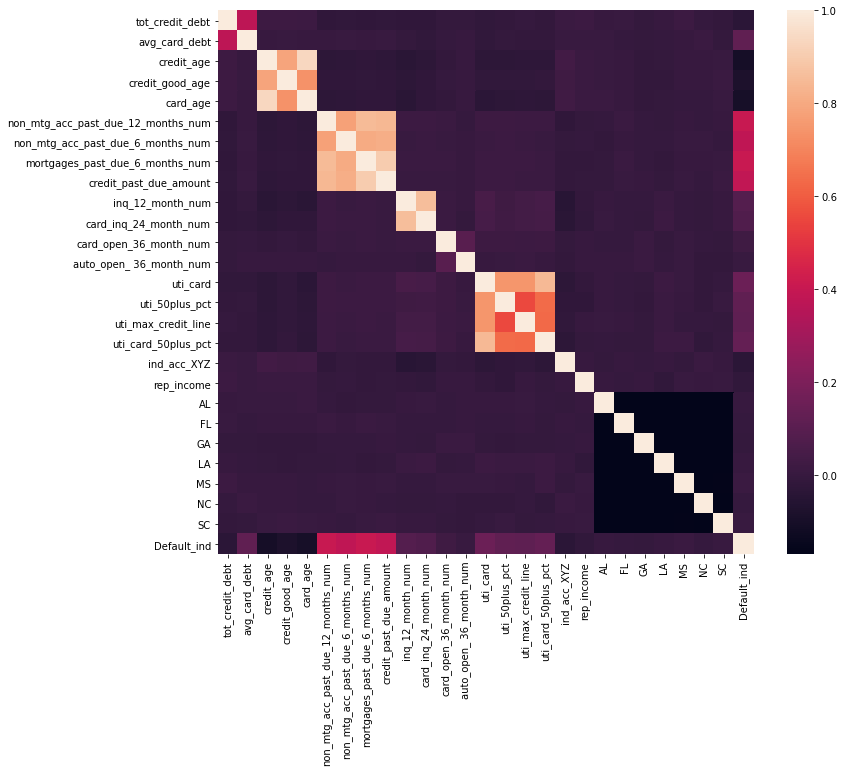

In [22]:
columns = []
fig, ax = plt.subplots(figsize=(12,10))
for num in range(0,27):
    columns.append(num)
corrMatrix = df_train.iloc[:,columns].corr()
sn.heatmap(corrMatrix, annot=False, ax=ax)
plt.show()

For logistic regression, we will need to deal with missing values, as the model will not do this for us. Since the only variable with missing values we decided to keep is uti_card_50plus_pct, we will need to find a way to deal with missing values for this column. Our first idea is, since utilization variables have high collinearity and are on the same scale, to combine all utilization variables into a mean utilization variable which will consider uti_card_50plus_pct only if available for the observation. To make sure this is feasable, we must first check the normality of the utilization variables. \
\
As can be seen below, the distribution of all utilization variables is approximately normal, meaning that mean utilization could be a useful variable.

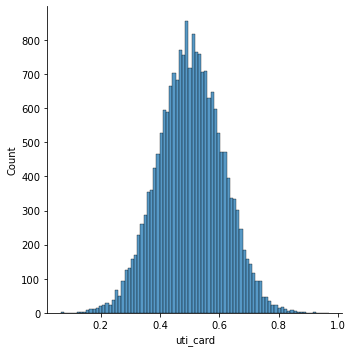

In [13]:
sn.displot(df_train,x="uti_card")

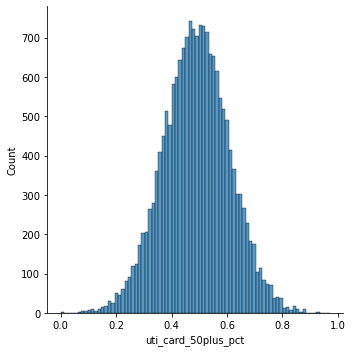

In [18]:
sn.displot(df_train,x="uti_card_50plus_pct")

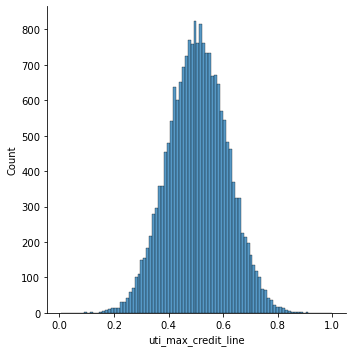

In [15]:
sn.displot(df_train,x="uti_max_credit_line")

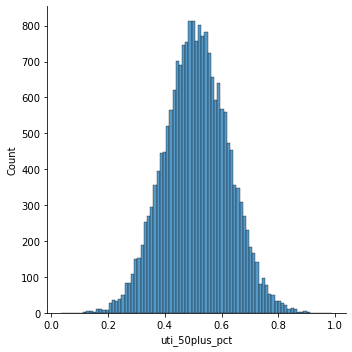

In [19]:
sn.displot(df_train,x="uti_50plus_pct")

#  **Data Preprocessing - Logistic Regression** <a name="sect2"></a>

We have already determined based on EDA which explanatory variables need to be dropped:tot_credit_debt, credit_age, credit_good_age, card_age, rep_income,inq_12_month_num.

In [205]:
df_train = df_train.drop(columns=["tot_credit_debt", "credit_age", "credit_good_age", "card_age","rep_income","inq_12_month_num"])

Next comes the process of combining all utilization variables into one variable, and replacing all the instances with the new overlapping variable. By taking the average utilization, we are able to preserve the available data in uti_card_50plus_pct.

In [206]:
util_vars = ["uti_card", "uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"]
util_credit = df_train[util_vars]
util_credit["mean"] = util_credit.mean(axis=1)

df_train = df_train.drop(columns=["uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"])
df_train["uti_card"] = util_credit["mean"]
df_train = df_train.rename(columns={"uti_card":"mean_uti"})

<ipython-input-206-543dfd05b1c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  util_credit["mean"] = util_credit.mean(axis=1)


Past due variables have unacceptable levels of colinearity. It makes sense to combine the non mortgage and mortgages past due 6 month variables as they span the same time period and are highly colinear. For now, the other past due variables are not dropped due to their high correlation with the response variable.

In [207]:
past_due_vars = ["non_mtg_acc_past_due_6_months_num", "mortgages_past_due_6_months_num"]
past_due_credit = df_train[past_due_vars]
past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"] 

df_train = df_train.drop(columns=["mortgages_past_due_6_months_num"])
df_train["non_mtg_acc_past_due_6_months_num"] = past_due_credit["past_due_6_months_num"]
df_train = df_train.rename(columns={"non_mtg_acc_past_due_6_months_num":"past_due_6_months_num"})

<ipython-input-207-db6338c54e88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"]


We will check collinearity and multicollinearity again to see if we have reduced it to an acceptable level. \
\
While colinearity between the past due variables' colinearity is worrying, they are simply too valuable to drop for now due to their high linearity with the response variable. The VIF values give an encouraging picture, however, as values, while slightly high, are in an acceptable range (1).

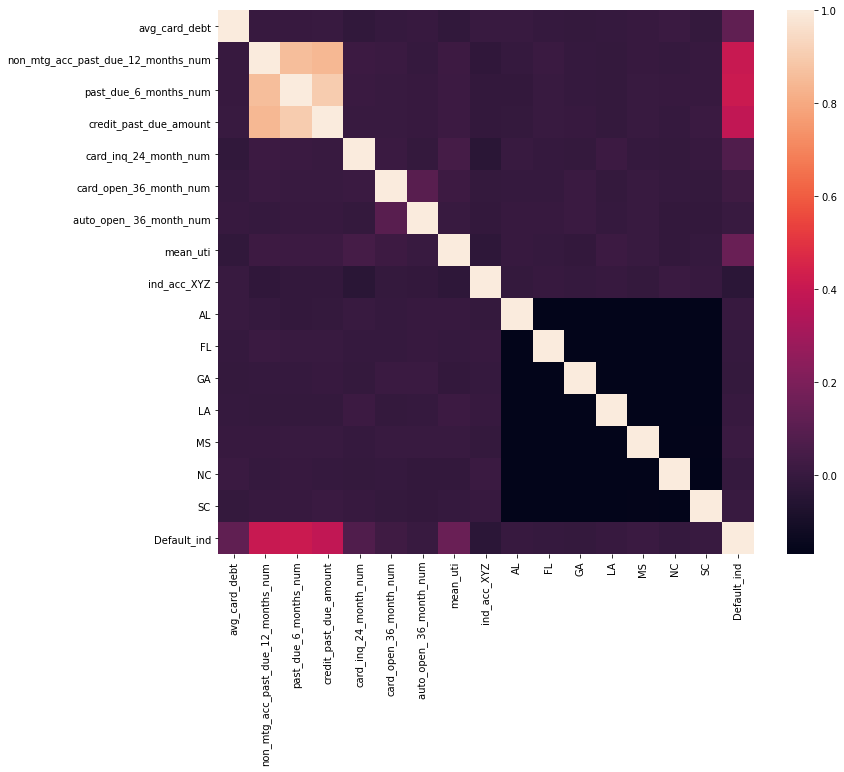

In [31]:
columns = []
fig, ax = plt.subplots(figsize=(12,10))
for num in range(0,17):
    columns.append(num)
corrMatrix = df_train.iloc[:,columns].corr()
sn.heatmap(corrMatrix, annot=False, ax=ax)
plt.show()

In [33]:
columns = []
for num in range(0,16):
     columns.append(num)

calc_vif(df_train.iloc[:,columns])

,variables,VIF
0,avg_card_debt,1.000904
1,non_mtg_acc_past_due_12_months_num,4.245805
2,past_due_6_months_num,6.522983
3,credit_past_due_amount,5.945257
4,card_inq_24_month_num,1.004331
5,card_open_36_month_num,1.010175
6,auto_open_ 36_month_num,1.009894
7,mean_uti,1.004178
8,ind_acc_XYZ,1.002969
9,AL,5.388244


Last thing left to do is normalize data:

In [208]:
df_train_norm=((df_train-df_train.min())/(df_train.max()-df_train.min()))*20

Check preprocessed data: \
\
Everything seems to be in order. Time to move on to model building.

In [36]:
print(df_train_norm.sample)
print(df_train_norm.shape)
print(df_train_norm.dtypes)

<bound method NDFrame.sample of        avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0           2.767399                                 0.0   
1           2.010511                                 0.0   
2           1.984746                                 0.0   
3           1.240052                                10.0   
4           1.689717                                 0.0   
...              ...                                 ...   
19995       2.364352                                 0.0   
19996       1.630937                                 0.0   
19997       3.170078                                 5.0   
19998       1.860892                                 0.0   
19999       1.575249                                 0.0   

       past_due_6_months_num  credit_past_due_amount  card_inq_24_month_num  \
0                   0.000000                0.000000               4.444444   
1                   0.000000                0.000000               4.444444   
2         

#  **Model Building and Testing - Logistic Regression** <a name="sect3"></a>

We will begin by performing hyper parameter optimization on the validation data set for logistic regression. In order to do this, we must manipulate the validation data set in the same way we have manipulated the training data set.

In [209]:
dummies = pd.get_dummies(df_validation['States'])
default_ind = df_validation['Default_ind']
df_validation = df_validation.drop(columns=["Default_ind","States","tot_credit_debt", "credit_age", "credit_good_age", "card_age","rep_income","inq_12_month_num"])
df_validation = df_validation.join(dummies)
df_validation = df_validation.join(default_ind)
util_vars = ["uti_card", "uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"]
util_credit = df_validation[util_vars]
util_credit["mean"] = util_credit.mean(axis=1)
df_validation = df_validation.drop(columns=["uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"])
df_validation["uti_card"] = util_credit["mean"]
df_validation = df_validation.rename(columns={"uti_card":"mean_uti"})
past_due_vars = ["non_mtg_acc_past_due_6_months_num", "mortgages_past_due_6_months_num"]
past_due_credit = df_validation[past_due_vars]
past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"] 
df_validation = df_validation.drop(columns=["mortgages_past_due_6_months_num"])
df_validation["non_mtg_acc_past_due_6_months_num"] = past_due_credit["past_due_6_months_num"]
df_validation = df_validation.rename(columns={"non_mtg_acc_past_due_6_months_num":"past_due_6_months_num"})
df_validation_norm=((df_validation-df_validation.min())/(df_validation.max()-df_validation.min()))*20

<ipython-input-209-959fbd1f3629>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  util_credit["mean"] = util_credit.mean(axis=1)
<ipython-input-209-959fbd1f3629>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"]


Everything looks in order:

In [39]:
print(df_validation_norm.sample)
print(df_validation_norm.shape)
print(df_validation_norm.dtypes)

<bound method NDFrame.sample of       avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0          1.258527                                 0.0   
1          2.838983                                 0.0   
2          1.565286                                 0.0   
3          2.258434                                 0.0   
4          2.612365                                 0.0   
...             ...                                 ...   
2995       1.765656                                 0.0   
2996       2.540309                                 0.0   
2997       1.908553                                 0.0   
2998       2.382803                                 0.0   
2999       1.846333                                 0.0   

      past_due_6_months_num  credit_past_due_amount  card_inq_24_month_num  \
0                       0.0                     0.0               0.000000   
1                       0.0                     0.0              10.769231   
2                       0

We will now perform hyperparamter tuning using our validation data set (2a). \
\
The parameters we have chosen are:
- solvers: newtown conjugate gradient, limited memory bfgs, and liblinear
- penalty: l2 only (since it works for all three solvers)
- C values: 100, 10, 1.0, 0.1, 0.01

In [210]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(df_validation_norm.iloc[:,range(0,16)], df_validation_norm.iloc[:,16])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937778 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.937667 (0.009195) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937667 (0.009195) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937667 (0.009195) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.937667 (0.009195) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937667 (0.009195) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937667 (0.009195) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.937667 (0.009195) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937667 (0.009195) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937667 (0.009195) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.937667 (0.009195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937667 (0.009195) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.937778 (0.009081) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.937778 (0.008664) wit

Based on this, the most accurate model has the following hyperparameters:
- solver: liblinear
- penalty: l2
- C value: 0.1

Train model based on chosen hyperparameters using the train data set:

In [211]:
lrModel = LogisticRegression(C = 0.1, penalty = "l2",solver="liblinear")
lrModel = lrModel.fit(df_train_norm.iloc[:,range(0,16)], df_train_norm.iloc[:,16])

Transforming test data to match training data:

In [212]:
dummies = pd.get_dummies(df_test['States'])
default_ind = df_test['Default_ind']
df_test = df_test.drop(columns=["Default_ind","States","tot_credit_debt", "credit_age", "credit_good_age", "card_age","rep_income","inq_12_month_num"])
df_test = df_test.join(dummies)
df_test = df_test.join(default_ind)
util_vars = ["uti_card", "uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"]
util_credit = df_test[util_vars]
util_credit["mean"] = util_credit.mean(axis=1)
df_test = df_test.drop(columns=["uti_50plus_pct", "uti_max_credit_line", "uti_card_50plus_pct"])
df_test["uti_card"] = util_credit["mean"]
df_test = df_test.rename(columns={"uti_card":"mean_uti"})
past_due_vars = ["non_mtg_acc_past_due_6_months_num", "mortgages_past_due_6_months_num"]
past_due_credit = df_test[past_due_vars]
past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"] 
df_test = df_test.drop(columns=["mortgages_past_due_6_months_num"])
df_test["non_mtg_acc_past_due_6_months_num"] = past_due_credit["past_due_6_months_num"]
df_test = df_test.rename(columns={"non_mtg_acc_past_due_6_months_num":"past_due_6_months_num"})
df_test_norm=((df_test-df_test.min())/(df_test.max()-df_test.min()))*20

<ipython-input-212-fd2b47dd7047>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  util_credit["mean"] = util_credit.mean(axis=1)
<ipython-input-212-fd2b47dd7047>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_due_credit["past_due_6_months_num"] = past_due_credit["non_mtg_acc_past_due_6_months_num"] + past_due_credit["mortgages_past_due_6_months_num"]


Check data:

In [43]:
print(df_test_norm.sample)
print(df_test_norm.shape)
print(df_test_norm.dtypes)

<bound method NDFrame.sample of       avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0          0.723813                                 0.0   
1          2.571408                                 0.0   
2          2.007778                                 0.0   
3          2.326841                                 0.0   
4          2.071129                                 0.0   
...             ...                                 ...   
4995       1.534659                                 0.0   
4996       2.550137                                 0.0   
4997       1.506616                                 0.0   
4998       1.193691                                 0.0   
4999       2.871439                                 0.0   

      past_due_6_months_num  credit_past_due_amount  card_inq_24_month_num  \
0                       0.0                     0.0               5.333333   
1                       0.0                     0.0               5.333333   
2                       0

Scoring test data:

In [139]:
lrModel.score(df_test_norm.iloc[:,range(0,16)], df_test_norm.iloc[:,16])

0.9358

Testing with a confusion matrix:

In [140]:
confusion_matrix(df_test_norm.iloc[:,16],lrModel.predict(df_test_norm.iloc[:,range(0,16)]))

array([[4552,   47],
       [ 274,  127]], dtype=int64)

Interpreting logistic regression model using ROC curve (2b):

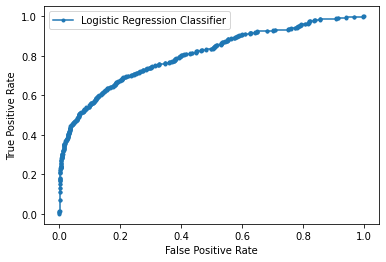

In [131]:
lr_probs = lr.predict_proba(df_test_norm.iloc[:,range(0,16)])
lr_probs = lr_probs[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(df_test_norm.iloc[:,16], lr_probs, pos_label = 20.0)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Find feature importance (2c): \
\
A positive score indicates the greater the value of the feature, the more likely the person is to default, while a negative score indicates the greater the value of the feature, the less likely the person is to default. \
\
A high absolute score indicates strong importance in model, while a low absolute score indicates weak importance in model. \
\
Important Notes: 
- Having had an account in XYZ does not seem to impact the model by much
- Average card debt, past due variables for 12 and 6 months, and utilization variables seem to have the greatest impact
- Although the state variables seem to cause a great impact, in reality each observation must be one of them, and thus, the difference between them is the only thing that matters for interpretation. In this case, since the importance of all state variables is very close overall, it seems that states do not have a great deal of impact on model prediction

Feature: avg_card_debt
 Score: 0.1499596391270964


Feature: non_mtg_acc_past_due_12_months_num
 Score: 0.23556759045910966


Feature: past_due_6_months_num
 Score: 0.1542133033538216


Feature: credit_past_due_amount
 Score: -0.04906488819908006


Feature: card_inq_24_month_num
 Score: 0.08606432328090474


Feature: card_open_36_month_num
 Score: 0.016807004273557042


Feature: auto_open_ 36_month_num
 Score: 0.006285595831829881


Feature: mean_uti
 Score: 0.27185106310181156


Feature: ind_acc_XYZ
 Score: -0.013710761590003758


Feature: AL
 Score: -0.3130380831427379


Feature: FL
 Score: -0.317889156327858


Feature: GA
 Score: -0.318481497908399


Feature: LA
 Score: -0.31415871337745066


Feature: MS
 Score: -0.3113582401283215


Feature: NC
 Score: -0.31565900138163133


Feature: SC
 Score: -0.3103977152431603




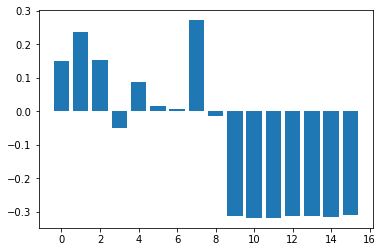

In [179]:
variables = []
for var in df_train_norm.columns:
    variables.append(var)
importance = lrModel.coef_[0]
index = 0
for i,v in enumerate(importance):
    print('Feature: {variable}\n Score: {v}\n\n'.format(variable = variables[index],v = v))
    index += 1
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#  **Data Preprocessing - Random Forests** <a name="sect4"></a>

We will reimport the data since we will be using a different approach to data preprocessing in preperation of random forest model.

In [144]:
df_test = pd.read_csv('Simulated_Data_Test.csv')
df_train = pd.read_csv('Simulated_Data_Train.csv')
df_validation = pd.read_csv('Simulated_Data_Validation.csv')

Based on EDA, we have determined which explanatory variables need to be dropped: rep_income, credit_age, credit_good_age, and card_age.

In [145]:
df_train = df_train.drop(columns=["credit_age", "credit_good_age", "card_age","rep_income"])

Next, let's create dummy variables for states

In [146]:
dummies = pd.get_dummies(df_train['States'])
default_ind = df_train['Default_ind']
df_train = df_train.drop(columns=['States', 'Default_ind'])
df_train = df_train.join(dummies)
df_train = df_train.join(default_ind)

We need to get rid of NA values next. let's check how many there are:

In [147]:
print(df_train.isnull().sum())

tot_credit_debt                          0
avg_card_debt                            0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_ 36_month_num                  0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
AL                                       0
FL                                       0
GA                                       0
LA                                       0
MS                                       0
NC                                       0
SC                                       0
Default_ind                              0
dtype: int6

We want to preserve the utilization features as we are not concenred with collinearity for this model. Thus, we have two options:
- Remove observations or column with missing values.
- Impute missing values for uti_card_50plus_pct

Removing observations will rid us of 10% of our data, which is not ideal. Removing uti_card_50plus_pct is detrimental since we will be getting rid of a feature which is highly correlated with the response variable. Thus we decide to impute the missing values of uti_card_50plus_pct. \
\
We know uti_card_50plus_pct is highly collinear with the other utilization features. Therefore, we will be using simple mean impuation with the utilization variables.

In [148]:
imputer = SingleImputer(
strategy='mean',
predictors=['uti_max_credit_line','uti_50plus_pct','uti_card'],
seed = 100)
imputed_df_train = imputer.fit_transform(df_train)

Check if imputation was succesful:

In [149]:
print(imputed_df_train.isnull().sum())

tot_credit_debt                       0
avg_card_debt                         0
non_mtg_acc_past_due_12_months_num    0
non_mtg_acc_past_due_6_months_num     0
mortgages_past_due_6_months_num       0
credit_past_due_amount                0
inq_12_month_num                      0
card_inq_24_month_num                 0
card_open_36_month_num                0
auto_open_ 36_month_num               0
uti_card                              0
uti_50plus_pct                        0
uti_max_credit_line                   0
uti_card_50plus_pct                   0
ind_acc_XYZ                           0
AL                                    0
FL                                    0
GA                                    0
LA                                    0
MS                                    0
NC                                    0
SC                                    0
Default_ind                           0
dtype: int64


Check data: \
\
Everything looks ready for the model.

In [150]:
print(imputed_df_train.sample)
print(imputed_df_train.shape)
print(imputed_df_train.dtypes)

<bound method NDFrame.sample of        tot_credit_debt  avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0             80826.71       15872.99                                 0.0   
1             96052.60       12178.02                                 0.0   
2             75212.76       12052.24                                 0.0   
3             70727.84        8416.80                                 2.0   
4             41604.47       10611.97                                 0.0   
...                ...            ...                                 ...   
19995        104765.01       13905.40                                 0.0   
19996         83990.07       10325.02                                 0.0   
19997        107606.69       17838.79                                 1.0   
19998         78787.72       11447.61                                 0.0   
19999         78296.90       10053.16                                 0.0   

       non_mtg_acc_past_due_6_months_num  m

# **Model Building and Testing - Random Forests** <a name="sect5"></a>

We will firstly preprocess the validation data set in same way as train set to prepare for hyperparameter tuning.

In [151]:
df_validation = df_validation.drop(columns=["credit_age", "credit_good_age", "card_age","rep_income"])
dummies = pd.get_dummies(df_validation['States'])
default_ind = df_validation['Default_ind']
df_validation = df_validation.drop(columns=['States', 'Default_ind'])
df_validation = df_validation.join(dummies)
df_validation = df_validation.join(default_ind)
imputed_df_validation = imputer.fit_transform(df_validation)

Check validation data: \
\
Everything looks in order.

In [152]:
print(imputed_df_validation.sample)
print(imputed_df_validation.shape)
print(imputed_df_validation.dtypes)

<bound method NDFrame.sample of       tot_credit_debt  avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0            63651.27        9019.99                                 0.0   
1           105559.29       16692.19                                 0.0   
2            96062.99       10509.13                                 0.0   
3            84417.40       13873.96                                 0.0   
4           100623.91       15592.09                                 0.0   
...               ...            ...                                 ...   
2995         90748.88       11481.81                                 0.0   
2996        101930.98       15242.30                                 0.0   
2997         74738.73       12175.49                                 0.0   
2998        120357.58       14477.70                                 0.0   
2999         74240.17       11873.45                                 0.0   

      non_mtg_acc_past_due_6_months_num  mortgages_past

We will now perform hyperparamter tuning using our validation data set (2a). \
\
The parameters we have chosen are:
- Number of estimators: 10, 100, 1000
- Max features: square root, log base 2

In [90]:
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(imputed_df_validation.iloc[:,range(0,22)], imputed_df_validation.iloc[:,22])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.941111 using {'max_features': 'log2', 'n_estimators': 100}
0.936222 (0.009574) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.940667 (0.010306) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.940556 (0.009929) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.937778 (0.009480) with: {'max_features': 'log2', 'n_estimators': 10}
0.941111 (0.010830) with: {'max_features': 'log2', 'n_estimators': 100}
0.940444 (0.010532) with: {'max_features': 'log2', 'n_estimators': 1000}


Based on this, the most accurate model has the following hyperparameters:
- Number of estimators: 100
- Max features: log base 2

Train model based on chosen hyperparameters using the train data set:

In [153]:
rfModel = RandomForestClassifier(max_features="log2",n_estimators=100)
rfModel = rfModel.fit(imputed_df_train.iloc[:,range(0,22)], imputed_df_train.iloc[:,22])

Transforming test data to match training data:

In [154]:
df_test = df_test.drop(columns=["credit_age", "credit_good_age", "card_age","rep_income"])
dummies = pd.get_dummies(df_test['States'])
default_ind = df_test['Default_ind']
df_test = df_test.drop(columns=['States', 'Default_ind'])
df_test = df_test.join(dummies)
df_test = df_test.join(default_ind)
imputed_df_test = imputer.fit_transform(df_test)

Check data:

In [155]:
print(imputed_df_test.sample)
print(imputed_df_test.shape)
print(imputed_df_test.dtypes)

<bound method NDFrame.sample of       tot_credit_debt  avg_card_debt  non_mtg_acc_past_due_12_months_num  \
0            40477.81        7766.64                                 0.0   
1           106760.98       16606.98                                 0.0   
2           121428.34       13910.13                                 0.0   
3            96515.05       15436.78                                 0.0   
4           123760.22       14213.25                                 0.0   
...               ...            ...                                 ...   
4995         90788.44       11646.36                                 0.0   
4996         91052.81       16505.20                                 0.0   
4997         71061.71       11512.18                                 0.0   
4998         82162.45       10014.90                                 0.0   
4999        116943.32       18042.56                                 0.0   

      non_mtg_acc_past_due_6_months_num  mortgages_past

Scoring test data:

In [156]:
rfModel.score(imputed_df_test.iloc[:,range(0,22)], imputed_df_test.iloc[:,22])

0.9366

Testing with a confusion matrix:

In [157]:
confusion_matrix(imputed_df_test.iloc[:,22],rfModel.predict(imputed_df_test.iloc[:,range(0,22)]))

array([[4568,   31],
       [ 286,  115]], dtype=int64)

ROC curve for random forest classifier (2b):

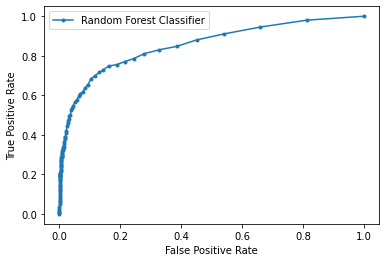

In [158]:
rf_probs = rfModel.predict_proba(imputed_df_test.iloc[:,range(0,22)])
rf_probs = rf_probs[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(imputed_df_test.iloc[:,22], rf_probs)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Find feature importance (2c): \
\
The higher the score, the more important the feature. \
\
Important Notes: 
- Despite not presenting much correlation with response variable, total credit debt and average card debt play the most important roles in determining defaults
- Utilization variables are all very important
- State, XYZ previous account indicator, and credit products opened in 36 months variables play a marginal role

Feature: tot_credit_debt
 Score: 0.10116110103522905


Feature: avg_card_debt
 Score: 0.15612549704029433


Feature: non_mtg_acc_past_due_12_months_num
 Score: 0.051588433741830204


Feature: non_mtg_acc_past_due_6_months_num
 Score: 0.026114066030776564


Feature: mortgages_past_due_6_months_num
 Score: 0.04471094287968974


Feature: credit_past_due_amount
 Score: 0.07272974478355873


Feature: inq_12_month_num
 Score: 0.040155479644069965


Feature: card_inq_24_month_num
 Score: 0.0476335411984235


Feature: card_open_36_month_num
 Score: 0.012521132722843388


Feature: auto_open_ 36_month_num
 Score: 0.009328620784239058


Feature: uti_card
 Score: 0.10270683546384929


Feature: uti_50plus_pct
 Score: 0.08696333953190324


Feature: uti_max_credit_line
 Score: 0.09047046122791504


Feature: uti_card_50plus_pct
 Score: 0.08913573380667056


Feature: ind_acc_XYZ
 Score: 0.011392454240505133


Feature: AL
 Score: 0.008526349581013072


Feature: FL
 Score: 0.00890519489911215


Feature: 

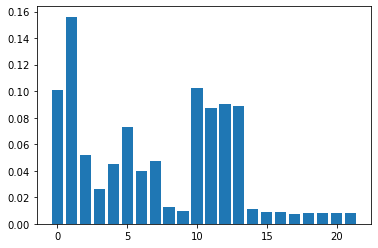

In [182]:
variables = []
for var in imputed_df_train.columns:
    variables.append(var)
importance = rfModel.feature_importances_
index = 0
for i,v in enumerate(importance):
    print('Feature: {variable}\n Score: {v}\n\n'.format(variable = variables[index],v = v))
    index += 1
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#  **Comparing Models** <a name="sect6"></a>

Comparing ROC curves and AUC (2b): \
\
Random forest performs better, as expected, because the true positive rate was better. This is confirmed by the AUC calculation as well.

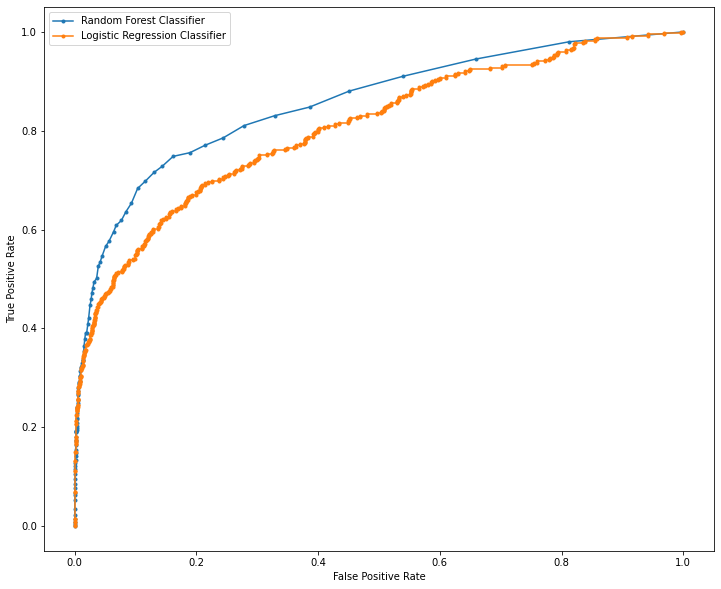

In [229]:
fig, ax = plt.subplots(figsize=(12,10))
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest Classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [136]:
lr_auc = roc_auc_score(df_test_norm.iloc[:,16], lr_probs)
rf_auc = roc_auc_score(imputed_df_test.iloc[:,22], rf_probs)
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

Logistic Regression: ROC AUC=0.806
Random Forest: ROC AUC=0.852


Comparing Learning curves (3):
- While the training score for the random forest model is very high (a natural consequence of an algorithm that is extremely robust), the cross validation scores are very comperable throughout
- Unsurpisingly, logistic regression is found to be much more scalable
- Model performence is slightly higher for random forest model

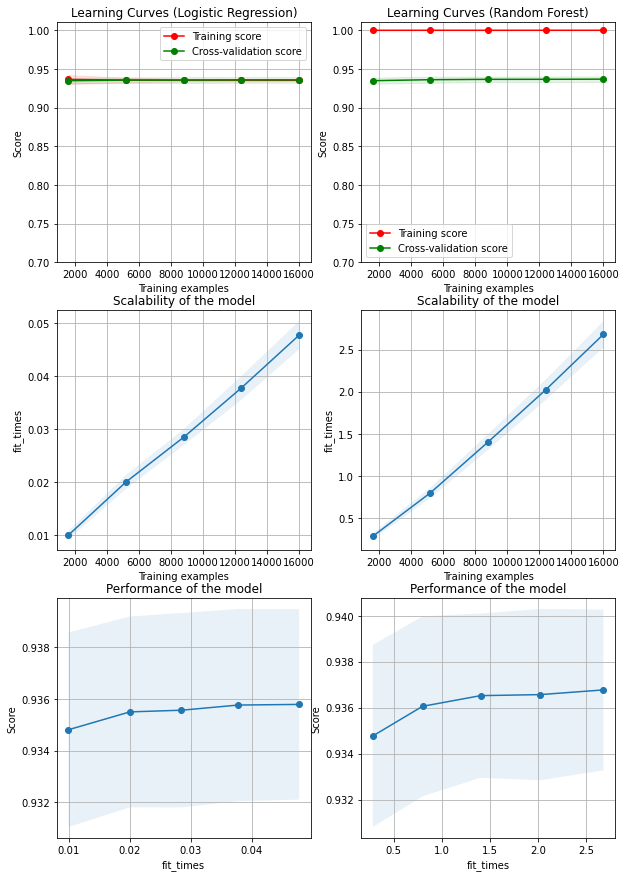

In [161]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = df_train_norm.iloc[:,range(0,16)], df_train_norm.iloc[:,16]
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(lrModel, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

X, y = imputed_df_train.iloc[:,range(0,22)], imputed_df_train.iloc[:,22]
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
plot_learning_curve(rfModel, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

#  **Code References** <a name="sect7"></a>
*Thank you to the following:* \
(1) Aniruddha Bhandari: \
[What is Multicollinearity? Here’s Everything You Need to Know](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/) \
(2) Jason Brownlee, PhD of Machine Learning Mastery: \
a. [Tune Hyperparameters for Classification Machine Learning Algorithms](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/) \
b. [How to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) \
c. [How to Calculate Feature Importance With Python](https://machinelearningmastery.com/calculate-feature-importance-with-python/) \
(3) SKLearn: \
[Plotting Learning Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)